In [2]:
import os

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import datetime as dt
import math
from datetime import datetime

# User input

In [3]:
# Filepath to baseline daily river data
fpath_baseline_data = r"/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/martini_rivers_v9_1990_2022_stage1data.nc"

# Filepath to river metadata csvs
real_riv_metadata = r"../data/real_river_metadata.csv"
riv_no_mapping_fpath = (
    r"/home/jovyan/shared/common/oslofjord_modelling/oslofjord_location_ids.csv"
)

# TEOTIL results (annual source apportionment)
# Baseline data
teotil_res_csv_fpath = (
    r"/home/jovyan/shared/common/teotil3/evaluation/teo3_results_nve2023_2013-2022.csv"
)
# WWTW scenario data
pc_reduction = 80  # 80 or 85%
teotil_scen_res_folder = f"/home/jovyan/shared/common/oslofjord_modelling/wastewater_scenarios/scen_totn_{pc_reduction}pct_effect"
teotil_scen_res_fname = "teo3_scenario_results_nve2023_2013-2022.csv"
teotil_scen_res_fpath = os.path.join(teotil_scen_res_folder, teotil_scen_res_fname)

# # Scenarios info
# scenario_setup_fpath = r"../data/md_of800_scenarios.csv"

# Start and end year to summarise TEOTIL data over
start_year = 2013  # 2016
end_year = 2022

# Folders for output files
netcdf_outfolder = r"/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/river_scenarios"
csv_exploration_folder = r"../output/csvs"
fig_folder = r"../output/plots"

# Real river numbers to use
# corresponding to model rivers 7-26 (incl). Drops Swedish rivers, don't make scens for those here
oslofjord_riv_nos = range(6, 21)

# species of interest  # only din works now
par = 'din'

# Set up & read in river metadata

In [12]:
if par in ['din', 'ton', 'totn']:
    species = 'N'
elif par in ['tdp', 'tpp', 'totp']:
    species = 'P'

riv_var_li_dict = {
    "N": [
        "river_NH4N",
        "river_NO3NO2N",
        "river_TOTN",
        "river_DON",
        "river_PON",
        "river_transport",
    ],
    "P": [
        "river_SRP",
        "river_TOTP",
        "river_DOP",
        "river_POP",
        "river_TIP",
        "river_transport",
    ],
}

derived_chemvar_dict = {
    "N": ['din', 'ton'],
    "P": ['tdp']
}

riv_var_li = riv_var_li_dict[species]
chem_var_li = riv_var_li.copy() + derived_chemvar_dict[species]
chem_var_li.remove('river_transport')

# Calculate start date (inclusive), end date (day after last day)
start_date = dt.datetime(start_year, 1, 1)
end_date = dt.datetime(end_year, 12, 31)
end_date += pd.Timedelta(days=1)

# River chemistry metadata
river_meta_df = pd.read_csv(real_riv_metadata, index_col=0, dtype={'Vassom':str})
# Limit to just Oslofjord rivers
river_meta_df = river_meta_df[river_meta_df.index.isin(oslofjord_riv_nos)]
# Add 'total' row for use later
river_meta_df.loc['Total', ['river_name', 'Regine', 'Regine_to_sea', 'Vassom']] = 'Total'
river_meta_df.query('real_river in @oslofjord_riv_nos')

,river_name,Outflow_lat,Outflow_lon,Regine,Regine_to_sea,Vassom,Vassom_area_land,Vassom_area_tot,Andre_MCA_area,Andre_area_q,Overestimate (%),Comment
real_river,,,,,,,,,,,,
6,Tista,59.119,11.370,001.A1,001.A1,001.,2495.0,2507.0,2507.0,1584.0,0.0,NaN
7,Glomma,59.206,10.953,002.A51,002.A11,002.,42446.0,43116.0,43116.0,41967.0,2.0,Monitoring point upstream of Sarpsborg RA. So ...
8,Mosseelva,59.439,10.662,003.A1,003.A1,003.,854.0,1052.0,1054.0,694.0,23.0,NaN
9,Hølenelva,59.523,10.690,004.A0,004.A0,004.,204.0,227.0,NaN,NaN,11.0,NaN
10,Årungen,59.720,10.728,005.3A,005.3A,005.,280.0,368.0,144.0,85.0,31.0,NaN
11,Akerselva,59.908,10.756,006.A10,006.A10,006.,392.0,415.0,415.0,307.0,6.0,NaN
12,Lysakerelva,59.914,10.640,007.A0,007.A0,007.,202.0,211.0,211.0,177.0,4.0,NaN
13,Sandvikselva,59.890,10.523,008.A11,008.A11,008.,279.0,311.0,311.0,226.0,11.0,NaN
14,Åros,59.704,10.519,009.A0,009.A0,009.,215.0,253.0,NaN,NaN,18.0,NaN


# TEOTIL source apportionment

## Read in data

In [13]:
def extract_source(col_name):
    """
    Function to rename teotil columns
    """
    parts = col_name.split('_')
    return parts[1]


def read_teotil_data(teotil_data_fpath):
    """
    Function to read raw TEOTIL data, pick the columns of interest (just accumulated inputs
    from all upstream areas), rename columns, truncate to the period of interest.

    Do this for both areas upstream of a given regine of interest, or whole vassdragsområder
    """
    df = pd.read_csv(teotil_data_fpath)

    # Just pick out accumulated inputs (from all upstream areas)
    # for the outflow reginer of interest
    cols = ["regine", "year"] + [
        col for col in df.columns if f"_{par}_" in col and col.startswith("accum")
    ]
    df = df.loc[df['regine'].isin(river_meta_df['Regine'])][cols]

    # Truncate to start of model period onwards (currently to 2022)
    df = df.loc[df['year'] >= start_year]

    # Rename columns
    cols_to_exclude = ['regine', 'year']
    new_col_names = {col: extract_source(col) for col in df.columns if col not in cols_to_exclude}
    new_col_names = cols_to_exclude + list(new_col_names.values())
    col_dict = dict(zip(df.columns, new_col_names))
    df = df.rename(columns=col_dict)

    return df


def teotil_average_over_years(res_df):
    """
    Average over all years to get a single value per main catchment area (or real river).
    Replace 'regine' index with river numbers
    """

    # Average over the year column per regine
    teotil_av_df = res_df.groupby('regine').mean().drop('year', axis=1)

    # Replace 'regine' index with river numbers, for easier matching to the river data
    mapping_dict = river_meta_df.reset_index().set_index('Regine')['real_river'].to_dict()
    teotil_av_df.index = teotil_av_df.index.map(mapping_dict)
    teotil_av_df.index.name = 'real_river'

    return teotil_av_df

In [14]:
# Read baseline TEOTIL data (units kg/yr) and average over time
bsl_teotil_df = read_teotil_data(teotil_res_csv_fpath)
bsl_teotil_av_df = teotil_average_over_years(bsl_teotil_df)

In [15]:
bsl_teotil_av_df.tail()

,agriculture-background,agriculture,aquaculture,industry,lake,large-wastewater,spredt,upland,urban,wood
real_river,,,,,,,,,,
16,1049.097702,9.441879e+03,0.0,0.000000,537.626966,0.000000,616.615375,3.215170,382.137931,777.134894
17,9257.656621,8.331891e+04,0.0,116.000000,3139.580272,2521.570000,6664.236901,151.254152,9312.260000,12411.591859
18,152385.602551,1.371470e+06,0.0,1730.744044,162055.470917,293117.886407,104904.368851,55312.229344,86514.504917,163153.074098
19,10792.854735,9.713569e+04,0.0,0.000000,1018.360754,0.000000,5728.975377,105.110621,6677.933120,7332.078445
20,47671.977257,4.290478e+05,0.0,0.000000,1491.200498,15823.959646,13729.389105,139.816137,13972.514280,12196.176469


## Define how TEOTIL sources are combined into different functional groups

In [16]:
# All sources considered  by TEOTIL
all_source_li = [
    "agriculture-background",  # Estimated natural runoff from agricultural land (i.e. non-human)
    "agriculture",
    "aquaculture",
    "industry",
    "lake",  # Direct deposition to lakes
    "large-wastewater",
    "spredt",  # Small works not connected to the main sewage system. Excludes watertight septic tanks
    "upland",
    "urban",  # Note: probably too big
    "wood",
]

point_source_li = ["aquaculture", "industry", "large-wastewater"]

diffuse_source_li = [
    "agriculture-background",
    "agriculture",
    "lake",
    "spredt",
    "upland",
    "urban",
    "wood",
]

human_diffuse_source_li = ['agriculture', 'spredt', 'urban']

human_source_li = [
    "agriculture",
    "aquaculture",
    "industry",
    "large-wastewater",
    "spredt",  # Small works not connected to the main sewage system. Excludes watertight septic tanks
    "urban",  # Note: probably too big
    # "lake"  # arguably mostly human, but not something local management can affect
]

natural_source_li = [
    "agriculture-background",  # Estimated natural runoff from agricultural land (i.e. non-human)
    "lake",  # Direct deposition to lakes (not really natural)
    "upland",
    "wood",  # Impacted by humans...
]

## TEOTIL proportion of load input per source per model river

Do this for all sources individually, and then split into point vs diffuse

In [17]:
# Total accumulated input per regine from all sources
teotil_total_s = bsl_teotil_av_df.sum(axis=1)

# Proportion per regine and source (checked that rows sum to 1, they do)
f_sector_df = bsl_teotil_av_df.divide(teotil_total_s, axis=0)
# print(f_sector_df.sum(axis=1).tail())

# Remove any rows where real_river=NaN, i.e. Sweden
f_sector_df = f_sector_df.reset_index()
f_sector_df = f_sector_df.dropna(subset=['real_river'])
f_sector_df = f_sector_df.set_index('real_river')

# Select just the Oslofjord rivers
f_sector_df = f_sector_df[f_sector_df.index.isin(oslofjord_riv_nos)]

# Also calculate for the whole Oslofjord
# Add as another row to f_sector_df with index='Total'
total_flux = bsl_teotil_av_df.sum().sum()
f_sector_df.loc['Total'] = bsl_teotil_av_df.sum(axis=0) / total_flux

f_sector_df.tail()

,agriculture-background,agriculture,aquaculture,industry,lake,large-wastewater,spredt,upland,urban,wood
real_river,,,,,,,,,,
17,0.072956,0.656607,0.0,0.000914,0.024742,0.019872,0.052519,0.001192,0.073387,0.097811
18,0.063742,0.573682,0.0,0.000724,0.067787,0.122610,0.043881,0.023137,0.036189,0.068246
19,0.083801,0.754212,0.0,0.000000,0.007907,0.000000,0.044483,0.000816,0.051851,0.056930
20,0.089261,0.803351,0.0,0.000000,0.002792,0.029629,0.025707,0.000262,0.026162,0.022836
Total,0.069844,0.628600,0.0,0.001597,0.037160,0.123839,0.033500,0.019121,0.034476,0.051862


In [18]:
# NOTE: needs generalising so that it sums over any sources in f_sector_df that
# are present in the different source lists

# Sum up to estimate point, diffuse, human sums
f_groupsector_df = pd.DataFrame(index=f_sector_df.index)
f_groupsector_df['point'] = f_sector_df[point_source_li].sum(axis=1)
f_groupsector_df['diffuse'] = f_sector_df[diffuse_source_li].sum(axis=1)
f_groupsector_df['human'] = f_sector_df[human_source_li].sum(axis=1)
f_groupsector_df['natural'] = f_sector_df[natural_source_li].sum(axis=1)

f_groupsector_df.tail()

,point,diffuse,human,natural
real_river,,,,
17,0.020786,0.979214,0.803298,0.196702
18,0.123334,0.876666,0.777087,0.222913
19,0.000000,1.000000,0.850545,0.149455
20,0.029629,0.970371,0.884849,0.115151
Total,0.125436,0.874564,0.822013,0.177987


In [19]:
# Sum up diffuse and point inputs in separate dfs
f_sector_df.drop('Total', axis=0, inplace=True)  # just in case
f_groupsector_df.drop('Total', axis=0, inplace=True)  # just in case

f_sector_diffuse_df = pd.DataFrame(index=f_sector_df.index)
for sector in diffuse_source_li:
    f_sector_diffuse_df[sector] = f_sector_df[sector] / f_groupsector_df['diffuse']

f_sector_point_df = pd.DataFrame(index=f_sector_df.index)
for sector in point_source_li:
    f_sector_point_df[sector] = f_sector_df[sector] / f_groupsector_df['point']

print(f_sector_diffuse_df.tail())
print(f_sector_point_df.tail())

            agriculture-background  agriculture      lake    spredt    upland  \
real_river                                                                      
16                        0.081911     0.737203  0.041977  0.048144  0.000251   
17                        0.074505     0.670545  0.025267  0.053633  0.001217   
18                        0.072710     0.654391  0.077324  0.050055  0.026392   
19                        0.083801     0.754212  0.007907  0.044483  0.000816   
20                        0.091987     0.827880  0.002877  0.026492  0.000270   

               urban      wood  
real_river                      
16          0.029837  0.060677  
17          0.074944  0.099888  
18          0.041280  0.077848  
19          0.051851  0.056930  
20          0.026961  0.023533  
            aquaculture  industry  large-wastewater
real_river                                         
16                  NaN       NaN               NaN
17                  0.0   0.04398           0

# Read in daily river data netcdf & tidy

In [20]:
ds = xr.open_dataset(fpath_baseline_data)

# Select just the variables of interest
ds = ds[riv_var_li_dict[species]]
ds

<xarray.Dataset> Size: 11MB
Dimensions:          (river_time: 12053, real_river: 39)
Coordinates:
  * real_river       (real_river) float64 312B 1.0 2.0 3.0 ... 37.0 38.0 39.0
  * river_time       (river_time) datetime64[ns] 96kB 1990-01-01T12:00:00 ......
Data variables:
    river_NH4N       (river_time, real_river) float32 2MB ...
    river_NO3NO2N    (river_time, real_river) float32 2MB ...
    river_TOTN       (river_time, real_river) float32 2MB ...
    river_DON        (river_time, real_river) float32 2MB ...
    river_PON        (river_time, real_river) float32 2MB ...
    river_transport  (river_time, real_river) float32 2MB ...
Attributes:
    river_main_station_names_1-10:   1=Göta älv, Alelyckan; 2=Bäveån Uddevall...
    river_main_station_names_11-20:  11=Akerselva, hovedmålestasjon; 12=Lysak...
    river_main_station_names_21-30:  21=Numedalslågen ved Bommestad (E18); 22...
    river_main_station_names_31-39:  31=Kvina; 32=Klostergrøften, Klostergrøf...
    history:                         Thu Mar 21 17:07:47 2024: ncks -4 -L 5 m...
    NCO:                             4.7.2

In [21]:
# Convert to dataframe
# N.B. loose units info then. m3/s for Q, ug/l for rest
conc_df = ds.to_dataframe()
ds.close()

conc_df = conc_df.reset_index()  # Drop multiindex

# # Add river name to df
# conc_df['river_name'] = conc_df['real_river'].map(river_meta_df['river_name'])

# Select just the Oslofjord rivers
conc_df = conc_df[conc_df['real_river'].isin(oslofjord_riv_nos)]

# Calculate DIN and TON
conc_df['din'] = conc_df['river_NH4N'] + conc_df['river_NO3NO2N']
# Assume particulate organic N = 0, and that this is more robust than TON = PON+DON
conc_df['ton'] = conc_df['river_TOTN'] - conc_df['din']

# Convert all numeric columns to float64 (chem cols were float32)
conc_df[riv_var_li] = conc_df[riv_var_li].astype(float)

# Round concentrations to 3 d.p. (N.B. only appropriate for ug/l)
conc_df[chem_var_li] = conc_df[chem_var_li].round(3)

# Truncate to start and end date
conc_df = conc_df.query('@start_date <= river_time <= @end_date')

conc_df.tail()

,river_time,real_river,river_NH4N,river_NO3NO2N,river_TOTN,river_DON,river_PON,river_transport,din,ton
470043,2022-12-31 12:00:00,16.0,9.192,1210.840,1338.208,101.914,16.116,0.731608,1220.031982,118.176003
470044,2022-12-31 12:00:00,17.0,39.270,866.487,1393.936,471.387,16.640,19.877710,905.757019,488.178986
470045,2022-12-31 12:00:00,18.0,13.546,342.997,508.703,135.739,16.272,258.239807,356.544006,152.158997
470046,2022-12-31 12:00:00,19.0,19.452,113.672,378.166,232.165,12.761,16.971445,133.123993,245.042007
470047,2022-12-31 12:00:00,20.0,274.545,1641.914,2143.350,209.739,16.999,39.055298,1916.458008,226.891998


In [22]:
# Explore for specific rivers/times
temp = conc_df.loc[conc_df['real_river'] == 14, ['river_time', 'river_NO3NO2N', 'river_transport']]

# Calculate daily & annual loads from the river data

## Daily loads

In [23]:
# Daily loads (kg/day)

# Make empty dataframe with just time & location info
daily_load_df = conc_df.drop(chem_var_li+['river_transport'], axis=1)

# Calculate load
for var in chem_var_li:
    # Units ug/l * m3/s * l/m3 * kg/ug * s/d = kg/d
    daily_load_df[var] = conc_df[var] * conc_df['river_transport'] * 10**3 * 10**-9 * 86400

chem_cols = daily_load_df.columns.drop(['river_time', 'real_river'])

daily_load_df.head()

,river_time,real_river,river_NH4N,river_NO3NO2N,river_TOTN,river_DON,river_PON,din,ton
327644,2013-01-01 12:00:00,6.0,99.304292,4136.529999,7003.108914,2526.572795,238.531498,4235.834311,2767.274610
327645,2013-01-01 12:00:00,7.0,692.954032,10022.521099,15417.079198,3971.521497,723.502474,10715.475200,4701.604138
327646,2013-01-01 12:00:00,8.0,199.130873,1214.673897,2189.321439,725.723523,49.342304,1413.806793,775.514680
327647,2013-01-01 12:00:00,9.0,68.907812,444.080250,735.532002,213.324874,9.136322,512.988079,222.544318
327648,2013-01-01 12:00:00,10.0,48.569385,674.590934,1159.604665,427.357783,9.005329,723.159846,436.444786


## Annual loads

In [24]:
# Annual loads (kg/year)
annual_load_df = daily_load_df.copy().set_index('river_time')
annual_load_df = annual_load_df.groupby('real_river').resample('YE').sum()

# Tidy
annual_load_df.drop('real_river', axis=1, inplace=True)
annual_load_df.reset_index(inplace=True)

# # Convert to tonnes (10**3 kg) per year
# annual_load_df[chem_cols] = annual_load_df[chem_cols]/1000

annual_load_df['year'] = annual_load_df['river_time'].dt.year
annual_load_df.drop('river_time', axis=1, inplace=True)

annual_load_df

,real_river,river_NH4N,river_NO3NO2N,river_TOTN,river_DON,river_PON,din,ton,year
0,6.0,12148.756964,4.696627e+05,8.548883e+05,348684.806476,24172.481743,4.818115e+05,373076.835932,2013
1,6.0,24691.520987,7.179538e+05,1.250792e+06,475092.293767,32759.244722,7.426454e+05,508146.259677,2014
2,6.0,12583.748320,6.601110e+05,1.144701e+06,440762.570758,30962.687071,6.726948e+05,472006.466481,2015
3,6.0,4797.933241,4.289918e+05,7.312321e+05,278736.468703,18537.616741,4.337896e+05,297442.459635,2016
4,6.0,13040.528094,5.503839e+05,9.138086e+05,329938.122509,20261.996188,5.634244e+05,350384.186715,2017
...,...,...,...,...,...,...,...,...,...
145,20.0,38339.002290,1.462085e+06,1.740374e+06,232419.643202,7462.601503,1.500424e+06,239950.040393,2018
146,20.0,91712.170890,1.822525e+06,2.073845e+06,143126.576566,16366.050079,1.914237e+06,159607.813147,2019
147,20.0,57215.250183,1.446076e+06,1.696930e+06,179414.366692,14098.026588,1.503292e+06,193638.226411,2020
148,20.0,84678.923005,1.018992e+06,1.320784e+06,208575.738556,8460.393411,1.103671e+06,217112.974208,2021


# Split river data annual loads by sector
Using proportions from TEOTIL averaged over the period 2013-2022 (at the moment)

In [25]:
# Just get annual loads for TEOTIL variable. Current one is din
annual_load_df_var = annual_load_df[['real_river', 'year', par]]
annual_load_df_var.set_index('real_river', inplace=True)

# Get the right f_sector_df and drop the 'total' row
# f_sector_df = f_sector_df.drop(['Total'], axis=0)

merged_df = annual_load_df_var.join(f_sector_df, how='left')
# Drop any Swedish rivers not present in TEOTIL
merged_df.dropna(how='any', inplace=True)

annual_sector_df = pd.DataFrame(index=merged_df.index)
annual_sector_df['year'] = merged_df['year']

for sector in f_sector_df.columns:
    annual_sector_df[sector] = merged_df[par] * merged_df[sector]

annual_sector_df.reset_index(inplace=True)

# Drop years outside the model data range
annual_sector_df = annual_sector_df.query('@start_year <= year <= @end_year')

annual_sector_df

,real_river,year,agriculture-background,agriculture,aquaculture,industry,lake,large-wastewater,spredt,upland,urban,wood
0,6.0,2013,33818.013412,3.043621e+05,0.0,22483.520377,40739.021478,23887.437691,15544.867313,1450.068900,12405.845761,27120.559836
1,6.0,2014,52125.768578,4.691319e+05,0.0,34655.222520,62793.540820,36819.165982,23960.252965,2235.079718,19121.887417,41802.574518
2,6.0,2015,47215.980962,4.249438e+05,0.0,31391.006241,56878.943156,33351.125316,21703.408481,2024.554924,17320.774290,37865.140725
3,6.0,2016,30447.395468,2.740266e+05,0.0,20242.603493,36678.591459,21506.593342,13995.521168,1305.541538,11169.363717,24417.472445
4,6.0,2017,39546.372598,3.559174e+05,0.0,26291.954625,47639.715054,27933.678416,18177.978323,1695.692893,14507.244789,31714.452037
...,...,...,...,...,...,...,...,...,...,...,...,...
145,20.0,2018,133929.637046,1.205367e+06,0.0,0.000000,4189.378183,44455.826966,38571.341184,392.799409,39254.376969,34263.934114
146,20.0,2019,170867.064783,1.537804e+06,0.0,0.000000,5344.797232,56716.622501,49209.211630,501.132412,50080.626816,43713.833466
147,20.0,2020,134185.603063,1.207670e+06,0.0,0.000000,4197.384913,44540.790840,38645.058644,393.550126,39329.399844,34329.419266
148,20.0,2021,98514.955789,8.866346e+05,0.0,0.000000,3081.591316,32700.483065,28372.017242,288.932437,28874.439570,25203.607124


In [26]:
# Sum up to estimate point, diffuse, human sums
annual_groupsector_df = annual_sector_df[['real_river', 'year']].copy()
annual_groupsector_df['point'] = annual_sector_df[point_source_li].sum(axis=1)
annual_groupsector_df['diffuse'] = annual_sector_df[diffuse_source_li].sum(axis=1)
annual_groupsector_df['human'] = annual_sector_df[human_source_li].sum(axis=1)
annual_groupsector_df['natural'] = annual_sector_df[natural_source_li].sum(axis=1)
annual_groupsector_df['total'] = annual_groupsector_df['point'] + annual_groupsector_df['diffuse']

annual_groupsector_df

,real_river,year,point,diffuse,human,natural,total
0,6.0,2013,46370.958068,4.354405e+05,3.786838e+05,103127.663626,4.818115e+05
1,6.0,2014,71474.388502,6.711710e+05,5.836884e+05,158956.963633,7.426454e+05
2,6.0,2015,64742.131557,6.079526e+05,5.287101e+05,143984.619767,6.726948e+05
3,6.0,2016,41749.196835,3.920404e+05,3.409406e+05,92849.000910,4.337896e+05
4,6.0,2017,54225.633041,5.091988e+05,4.428282e+05,120596.232581,5.634244e+05
...,...,...,...,...,...,...,...
145,20.0,2018,44455.826966,1.455968e+06,1.327648e+06,172775.748752,1.500424e+06
146,20.0,2019,56716.622501,1.857520e+06,1.693810e+06,220426.827892,1.914237e+06
147,20.0,2020,44540.790840,1.458751e+06,1.330186e+06,173105.957368,1.503292e+06
148,20.0,2021,32700.483065,1.070970e+06,9.765815e+05,127089.086665,1.103671e+06


# Estimate daily loads from point sources vs diffuse sources
Key assumptions: constant daily load from point sources, irrespective of discharge; input from diffuse sources increases with discharge in an undefined way. So first estimate point source contribution to load, then estimate diffuse input by difference:
- Total daily load (already calculated above), L_tot =C_t Q_t
- Daily load from point sources, L(pt,daily) = L_pt,whole-period / number of days in the model period
- Daily load from diffuse sources, L(diffuse, daily) = L(tot, daily) - L(pt, daily)
- Plots to check looks sensible. What to do with negative values?e


In [27]:
# Estimate point sources as a constant daily input over the whole period

# Sum up over the whole model period (start of start year to end of end year)
annual_point_df_sum = (
    annual_groupsector_df[["real_river", "year", "point"]].groupby("real_river").sum()
)
annual_point_df_sum.drop("year", axis=1, inplace=True)

# Divide by the number of days in the whole model period
tot_days = end_date - start_date
tot_days = tot_days.days

daily_point_df = annual_point_df_sum / tot_days
daily_point_df.head()

,point
real_river,
6.0,179.041432
7.0,3295.989665
8.0,16.850147
9.0,7.734803
10.0,2.259376


In [28]:
# Get daily load data for just the TEOTIL chemical variable of interest
daily_load_df_var = daily_load_df[['real_river', 'river_time', par]].copy()

# Reformat & rename columns
daily_load_df_var.columns = ['real_river', 'date', 'total']
# Drop 12:00 time info from the dates, for compatibility with other dfs
daily_load_df_var['date'] = daily_load_df_var['date'].dt.normalize()
daily_load_df_var.set_index(['real_river', 'date'], inplace=True)
# print(daily_load_df_var.head())

# Join the daily load df with the estimated daily point inputs
calc_load_df = daily_load_df_var.join(daily_point_df, on='real_river', how='outer')

# Estimate diffuse inputs by subtracting point from total
calc_load_df['diffuse_raw'] = calc_load_df['total'] - calc_load_df['point']

calc_load_df

total       point  diffuse_raw
real_river date                                            
6.0        2013-01-01  4235.834311  179.041432  4056.792879
           2013-01-02  3918.087439  179.041432  3739.046007
           2013-01-03  1991.311006  179.041432  1812.269574
           2013-01-04  1963.764012  179.041432  1784.722580
           2013-01-05  1890.143944  179.041432  1711.102512
...                            ...         ...          ...
20.0       2022-12-27  6312.893951   98.408537  6214.485414
           2022-12-28  6352.336934   98.408537  6253.928397
           2022-12-29  6391.311161   98.408537  6292.902625
           2022-12-30  6429.546008   98.408537  6331.137471
           2022-12-31  6466.853230   98.408537  6368.444694

[54780 rows x 3 columns]

## Plot uncorrected

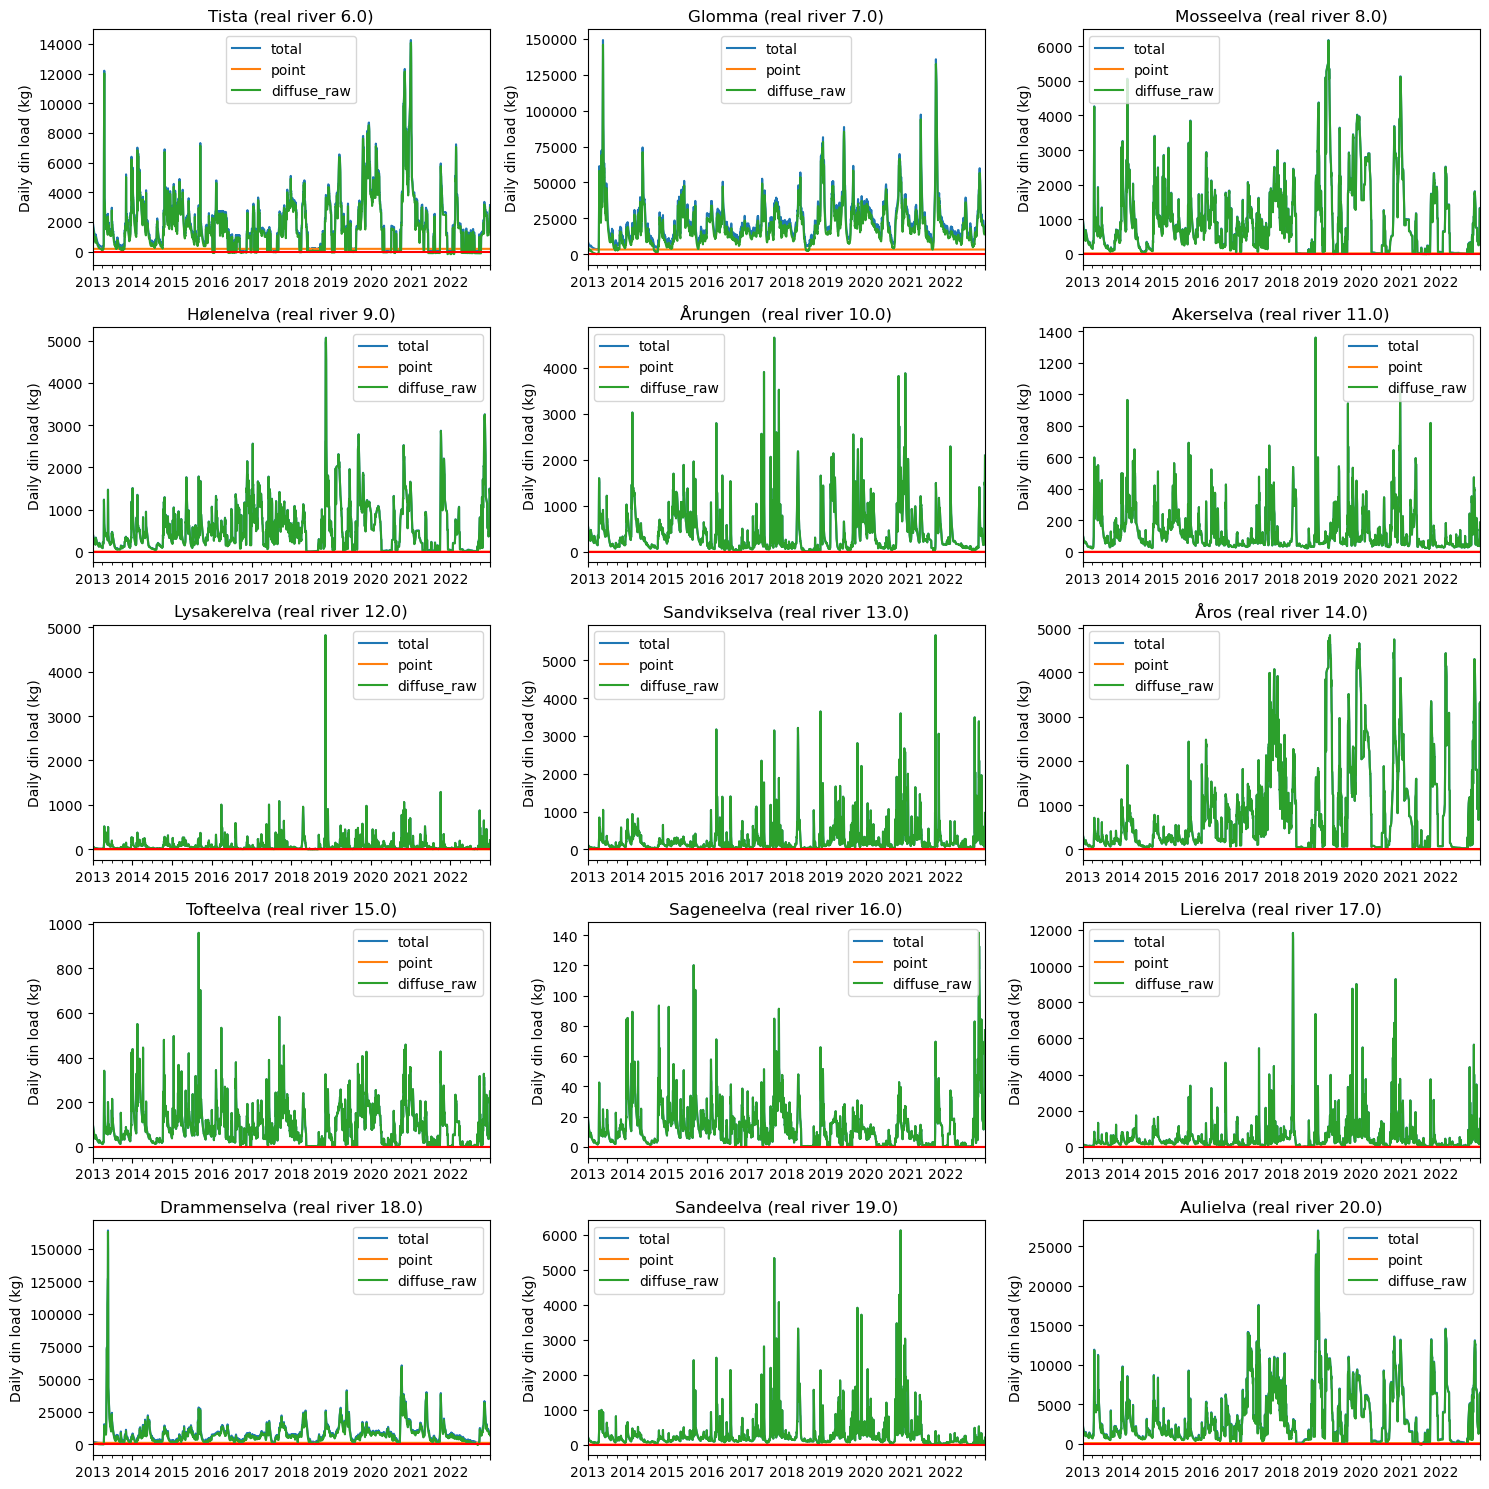

In [29]:
real_rivers = calc_load_df.index.get_level_values('real_river').unique()

n_rows = int(np.ceil(len(real_rivers) / 3))
fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows*3))
axs = axs.flatten()

# For each real_river
for i, real_river in enumerate(real_rivers):
    name = river_meta_df.loc[real_river, 'river_name']
    df = calc_load_df.loc[real_river]
    df.plot(ax=axs[i])
    axs[i].axhline(0, color='r')
    axs[i].set_xlabel('')
    axs[i].set_ylabel(r'Daily %s load (kg)' % par)
    axs[i].set_title(f'{name} (real river {real_river})')
    axs[i].legend()

plt.tight_layout()
plt.show()

**Comments**

**This is extremely influenced by the choice of whether to summarise TEOTIL inputs over the whole vassdragsområde or just the downstream regine associated with the main river**. The whole vassdragsområde includes point source inputs directly to the sea (e.g. VEAS), so of course this approach won't work for the whole vassdragsområde, unless these direct land-sea fluxes are first subtracted from the TEOTIL point sources. Perhaps something to look into for the future. For now, just go with the downstream REGINE as the TEOTIL unit.

Then, point source inputs are minor. The river with the highest point source inputs is in fact Glomma, at 20%. The approach works well everywhere including there, i.e. after subtracting daily point inputs during low flows, we're not going particularly negative.

There are however small negative values that need to be removed. These are small, so it's not worth fiddling too much... Approach: sum up the absolute of the negative over the whole period, divide by the days in the period, and then subtract from the diffuse load for days where this is > (total - point) inputs

## Redistribute negative mass

In [30]:
def remove_negatives(row):
    if row['point'] > row['total']:
        row['leftover'] = row['point'] - row['total']
        row['point'] = row['total']
        row['diffuse'] = 0
    else:
        row['point'] = row['point']
        row['diffuse'] = row['diffuse']
        row['leftover'] = 0
    return row

def redistribute_leftover(df):
    leftover_mass = df['leftover'].sum()
    n_days = len(df[df['diffuse'] > 0])
    mask = df['diffuse'] > 0
    df.loc[mask, 'point'] = df.loc[mask, 'point'] + leftover_mass / n_days
    df.loc[mask, 'diffuse'] = df.loc[mask, 'total'] - df.loc[mask, 'point']
    df['leftover'] = 0
    return df


In [31]:
# Apply to real data
calc_load_df = daily_load_df_var.join(daily_point_df, on='real_river', how='outer')

riv_nos = calc_load_df.index.get_level_values(0).unique().tolist()

daily_load_dict = {}  # Do away with multi-indexing! Use a dict instead from now on
                      # Key: river number, returns df with datetime index, one col per source
                      # or combined sources

# Apply to real data
for riv_no in riv_nos:
    df = calc_load_df.loc[riv_no].copy()

    df['diffuse_raw'] = df['total'] - df['point']
    df['diffuse'] = df['diffuse_raw']
    df['leftover'] = 0
    df['point_raw'] = df['point']

    # print(f'Start {riv_no}')
    # print(df.round(1))

    counter = 0
    max_iterations = 20
    while len(df.loc[df['diffuse'] < 0]) > 0:
        # print('iteration %s' % counter)
        if counter >= max_iterations:
            print(f"Maximum number of iterations reached: {max_iterations}")
            break
        df = df.apply(remove_negatives, axis=1)
        df = redistribute_leftover(df)
        counter += 1

    print(f"River {riv_no}: {counter} iterations to redistribute mass")

    # Check original point source inputs and final ones are equal
    if df['point_raw'].sum().round(1) != df['point'].sum().round(1):
        print("New point source doesn't add up")

    df = df[['total', 'diffuse', 'point']]
    daily_load_dict[riv_no] = df

River 6.0: 3 iterations to redistribute mass
River 7.0: 0 iterations to redistribute mass
River 8.0: 2 iterations to redistribute mass
River 9.0: 0 iterations to redistribute mass
River 10.0: 0 iterations to redistribute mass
River 11.0: 0 iterations to redistribute mass
River 12.0: 0 iterations to redistribute mass
River 13.0: 0 iterations to redistribute mass
River 14.0: 0 iterations to redistribute mass
River 15.0: 0 iterations to redistribute mass
River 16.0: 0 iterations to redistribute mass
River 17.0: 1 iterations to redistribute mass
River 18.0: 1 iterations to redistribute mass
River 19.0: 0 iterations to redistribute mass
River 20.0: 1 iterations to redistribute mass


## Plot result

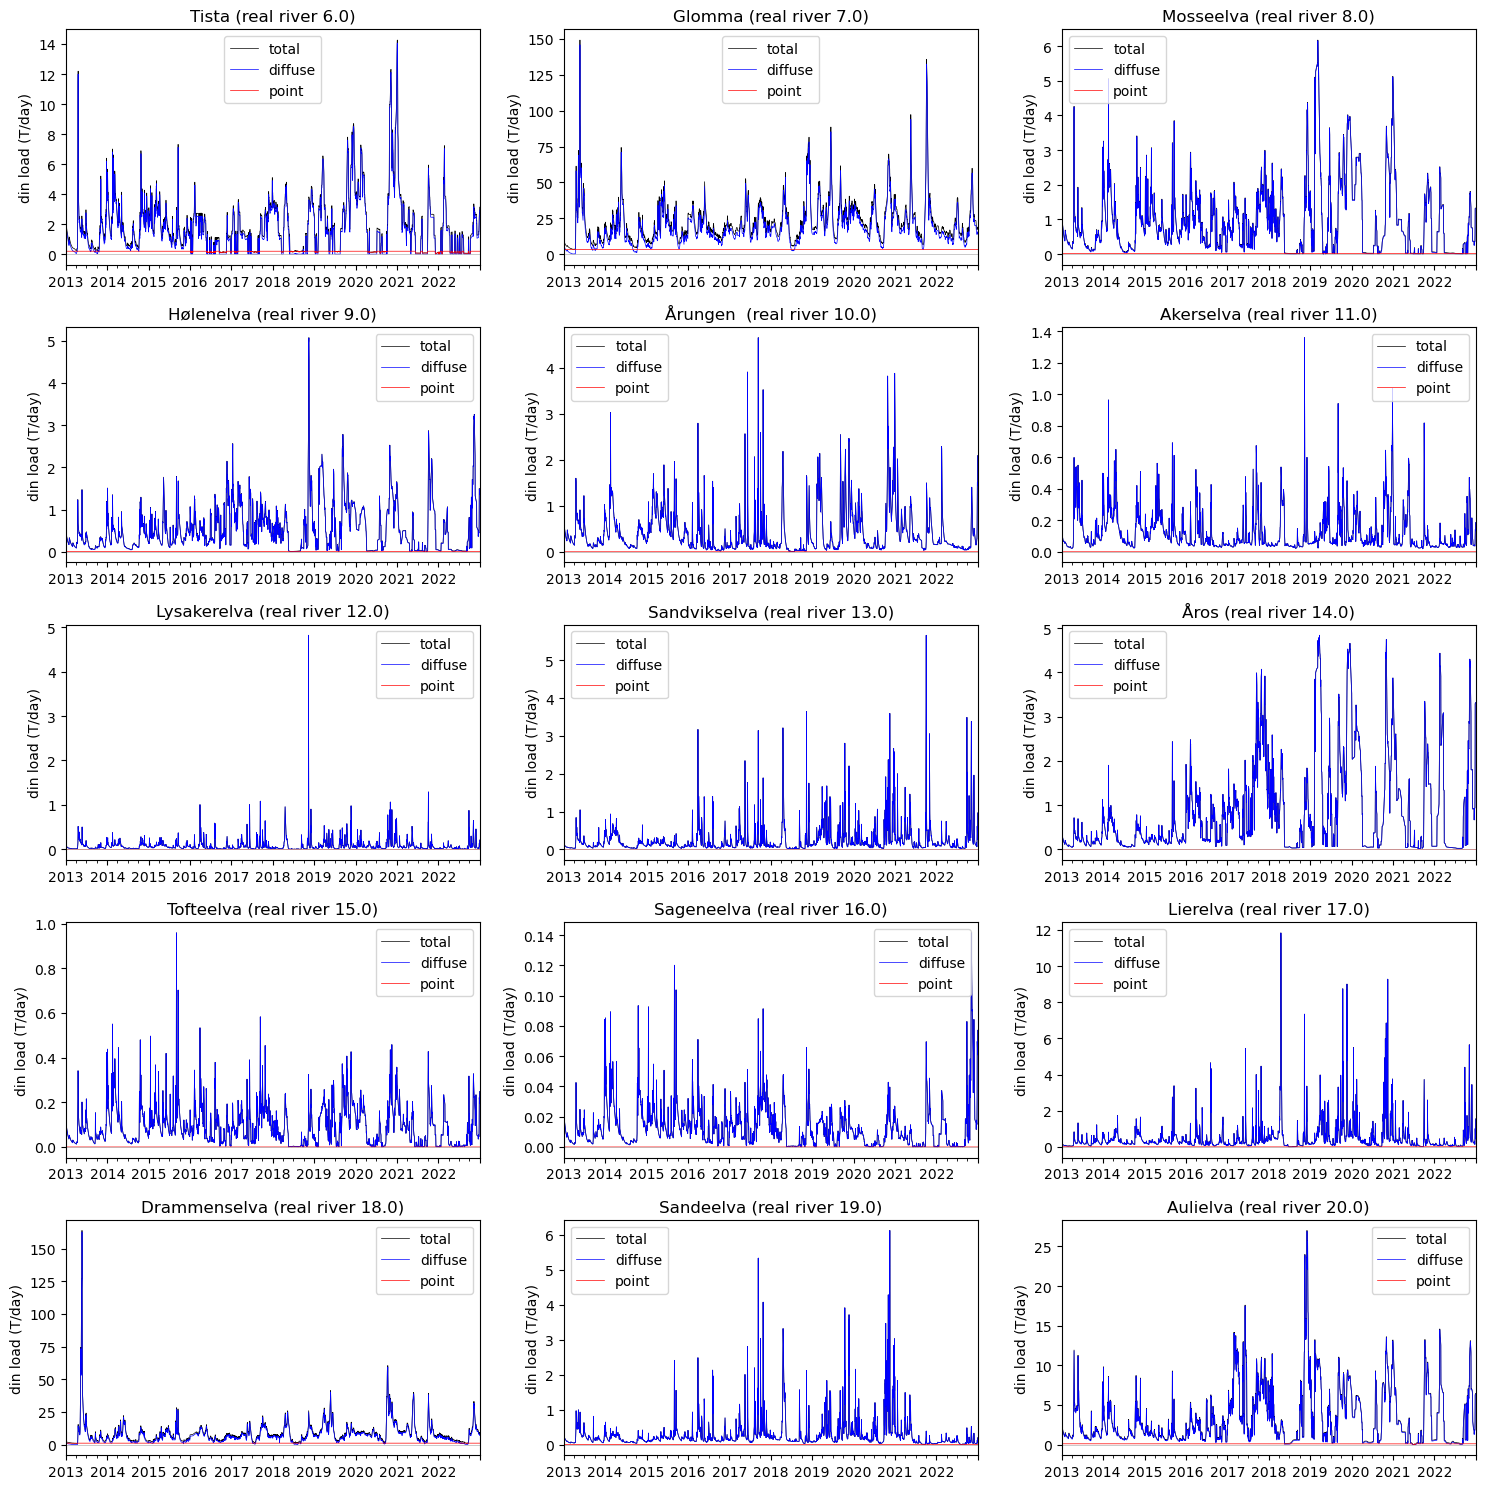

In [32]:
n_rows = int(np.ceil(len(real_rivers) / 3))
fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows * 3))
axs = axs.flatten()
color_li = ["k", "b", "r"]

# For each real_river
for i, real_river in enumerate(real_rivers):
    name = river_meta_df.loc[real_river, "river_name"]
    df = daily_load_dict[real_river] / 1000
    df.plot(ax=axs[i], color=color_li, linewidth=0.5)
    axs[i].axhline(0, color="0.7", linewidth=0.5)
    axs[i].set_xlabel("")
    axs[i].set_ylabel(r"%s load (T/day)" % par)
    axs[i].set_title(f"{name} (real river {real_river})")
    axs[i].legend()

plt.tight_layout()
fpath = os.path.join(fig_folder, "daily_riv-only_pt-vs-diffuse_ts.png")
plt.savefig(fpath)
plt.show()

# Daily loads from all sectors

Do this based on:
1) The proportion of point source inputs which are large sewage vs industry
2) The proportion of diffuse source inputs which are agriculture, urban and spredt (the rest are "natural")

Then estimate daily loads as this proportion multiplied by the total daily load from point of diffuse sources.

In [33]:
for riv_no in riv_nos:
    # Alter df inplace in the dictionary (unless make a copy here)
    df = daily_load_dict[riv_no]

    for source in human_diffuse_source_li:
        df[source] = f_sector_diffuse_df.loc[riv_no, source] * df["diffuse"]

    for source in point_source_li:
        df[source] = f_sector_point_df.loc[riv_no, source] * df["point"]
        # f_sector_point_df has NaNs where the total point load was 0. Results in
        # NaNs for the daily load per sector. Replace with 0
        df[source]= df[source].fillna(0)

    df["background"] = df["total"] - df[human_diffuse_source_li + point_source_li].sum(axis=1)

    # Rename 'spredt'
    df.rename(columns={"spredt": "small-wastewater"}, inplace=True)

If none of the rivers have any aquaculture inputs (they probably shouldn't), then drop this column altogether

In [34]:
rivs_with_aquaculture = []
for riv_no in riv_nos:
    # Alter df inplace in the dictionary (unless make a copy here)
    df = daily_load_dict[riv_no]
    if df['aquaculture'].eq(0).all():
        # print(f'{riv_no}: all aquaculture inputs = 0')
        pass
    else:
        rivs_with_aquaculture.append(riv_no)

if len(rivs_with_aquaculture) == 0:
    print('Dropping aquaculture column')
    for riv_no in riv_nos:
        df = daily_load_dict[riv_no]
        df.drop('aquaculture', axis=1, inplace=True)
else:
    print(f'Rivers with aquaculture inputs: {rivs_with_aquaculture}')

Dropping aquaculture column


In [35]:
# Quick look at output e.g. for Glomma
daily_load_dict[7].head()

,total,diffuse,point,agriculture,small-wastewater,urban,industry,large-wastewater,background
date,,,,,,,,,
2013-01-01,10715.475200,7419.485535,3295.989665,5443.613358,268.255362,245.637937,7.175898,3288.813767,1461.978879
2013-01-02,9554.927811,6258.938146,3295.989665,4592.129621,226.295167,207.215533,7.175898,3288.813767,1233.297825
2013-01-03,8966.079073,5670.089408,3295.989665,4160.096316,205.005034,187.720437,7.175898,3288.813767,1117.267621
2013-01-04,8819.291185,5523.301520,3295.989665,4052.399293,199.697841,182.860710,7.175898,3288.813767,1088.343676
2013-01-05,8609.265870,5313.276205,3295.989665,3898.305508,192.104267,175.907372,7.175898,3288.813767,1046.959058


## Plot by real river

**To do:**
- Turn into stacked line chart?
- Use this function for plots above (& move function up!)

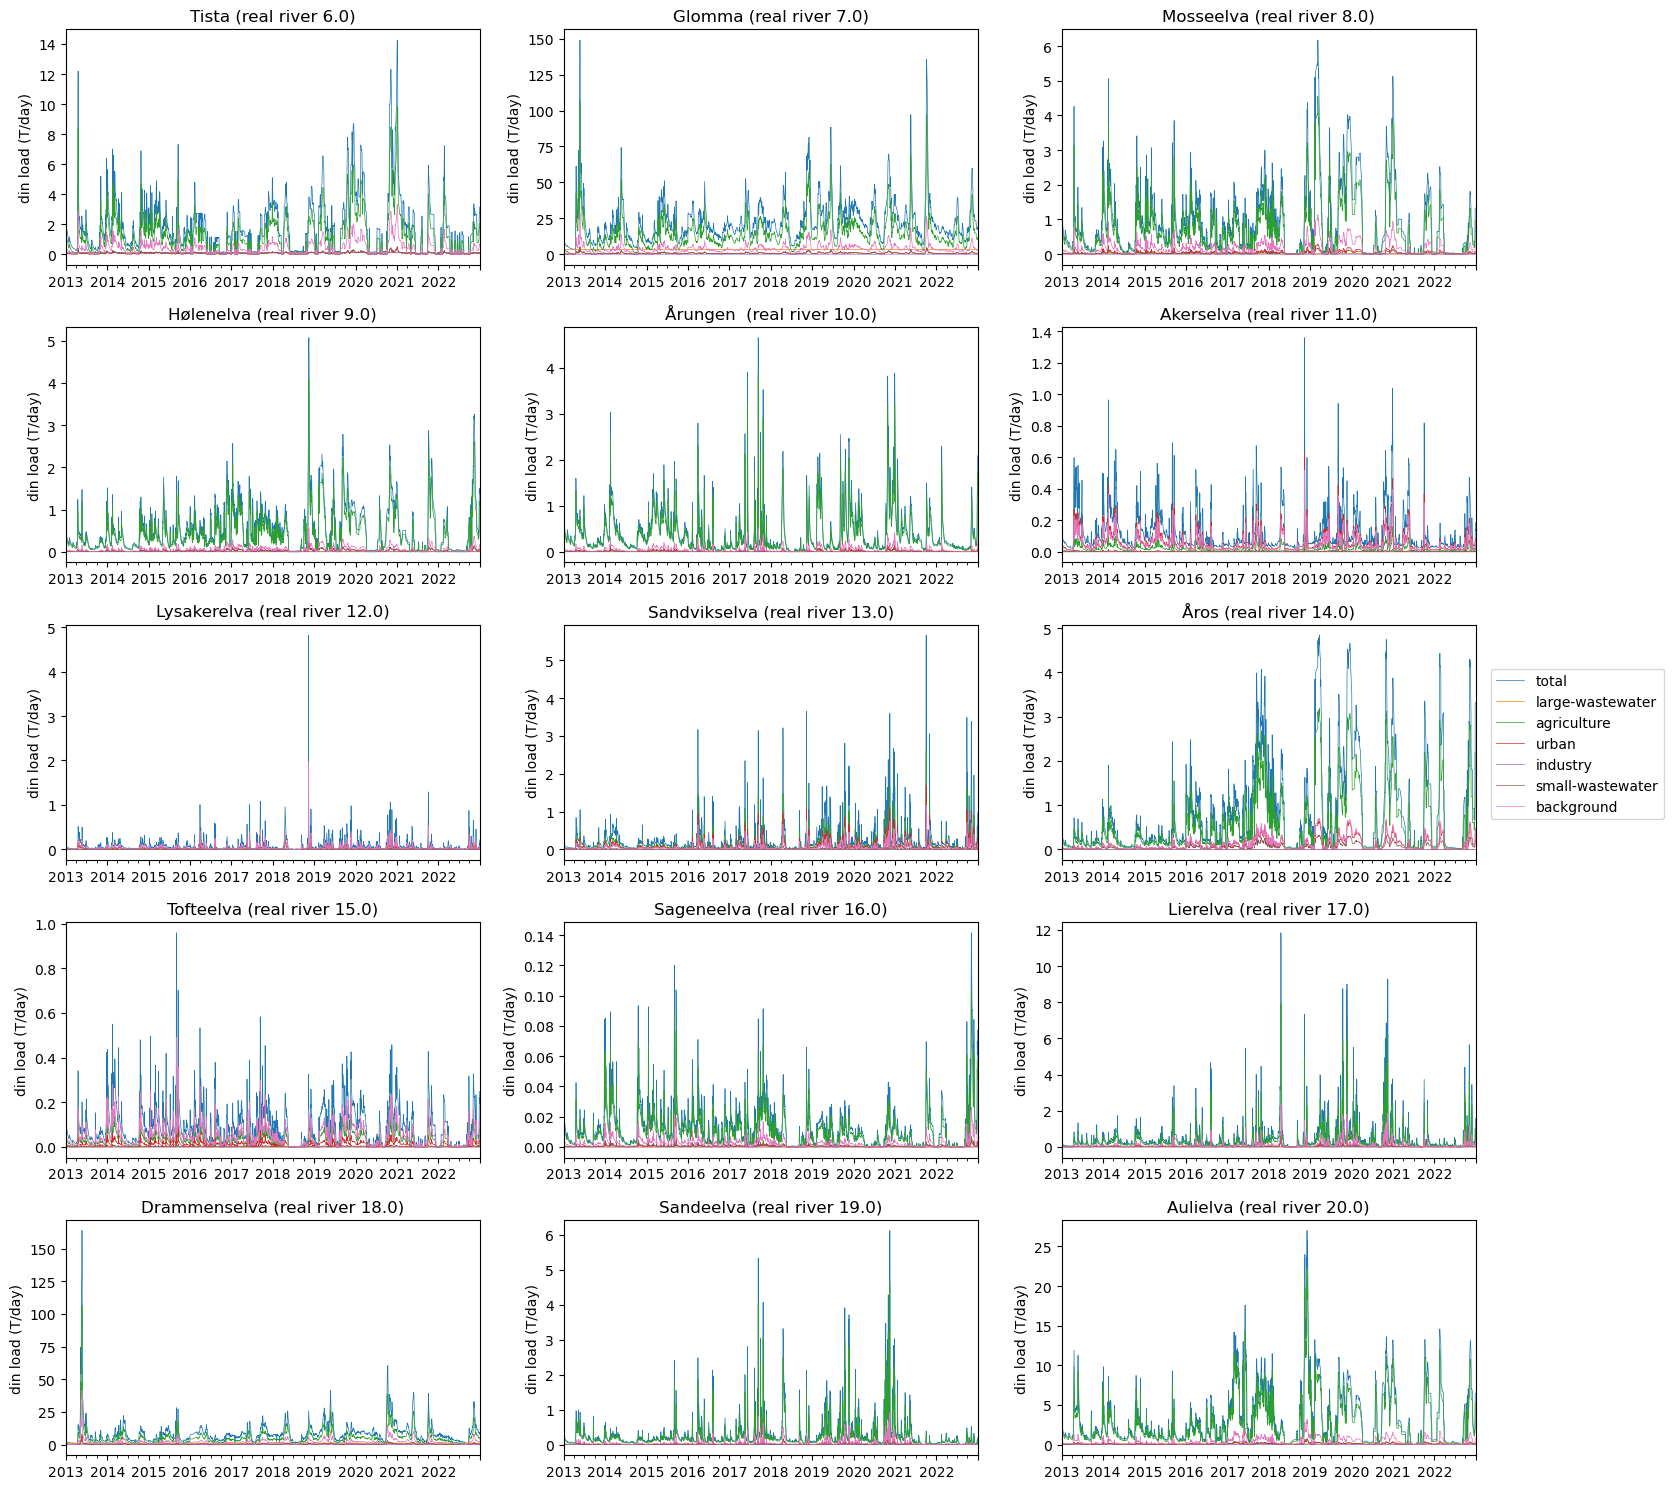

In [36]:
cols_to_plot = ['total', 'large-wastewater', 'agriculture', 'urban', 'industry', 'small-wastewater', 'background']


def plot_timeseries_allrivs(real_rivers_li, daily_load_dict, cols_to_plot, fpath):
    n_rows = int(np.ceil(len(real_rivers_li) / 3))
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows*3), sharex=False, sharey=False)
    axs = axs.flatten()
    # color_li = ['k', 'r', '']

    # For each real_river
    for i, real_river in enumerate(real_rivers_li):
        name = river_meta_df.loc[real_river, 'river_name']
        df = daily_load_dict[real_river].copy()/1000  # to T/yr
        df[cols_to_plot].plot(ax=axs[i], linewidth=0.5, legend=False)
        axs[i].set_xlabel('')
        axs[i].set_ylabel(r'%s load (T/day)' % par)
        axs[i].set_title(f'{name} (real river {real_river})')

    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.12, 0.5))

    plt.tight_layout()
    # fig.autofmt_xdate()

    plt.savefig(fpath)

    plt.show()

fpath = os.path.join(fig_folder, "daily_riv-only_sector-inputs_ts.png")
plot_timeseries_allrivs(real_rivers, daily_load_dict, cols_to_plot, fpath)

# Generate scenarios

## WWTW scenarios
For WWTW, the scenario is generated externally using TEOTIL. Here, James converted all WWTWs to have 80% treatment efficiency and then re-ran TEOTIL.

In [37]:
# Read scenario teotil data and average over time
scen_teotil_df = read_teotil_data(teotil_scen_res_fpath)
scen_teotil_av_df = teotil_average_over_years(scen_teotil_df)

# Calculate factor reductions from  this scenario per real river
col = 'large-wastewater'
f_wwtw_scenario_df = scen_teotil_av_df[col] / bsl_teotil_av_df[col]

# Have some NaNs (when baseline large wwtw inputs = 0). Replace any NaNs with 0
# (i.e. no change)
f_wwtw_scenario_df.fillna(0, inplace=True)

f_wwtw_scenario_df

real_river
6     0.228189
7     0.296954
8     0.247137
9     0.237242
10    0.225176
11    0.221884
12    0.225553
13    0.228480
14    0.000000
15    0.000000
16    0.000000
17    0.246069
18    0.237908
19    0.000000
20    0.230426
Name: large-wastewater, dtype: float64

The new WWTW inputs are around 23-30% of the original, i.e. a 70-80'ish percent reduction

In [38]:
wwtw_scen_load_dict = {}  # key: real riv no

for riv_no in daily_load_dict.keys():
    # Copy baseline data
    scen_load_df = daily_load_dict[riv_no].copy()[['agriculture', 'small-wastewater', 'urban', 'industry', 'background', 'large-wastewater']]

    # Reduce large wastewater by a set proportion per real river
    scen_load_df['large-wastewater'] = scen_load_df['large-wastewater'] * f_wwtw_scenario_df.loc[riv_no]

    # Add new total column
    scen_load_df['total'] = scen_load_df.sum(axis=1)

    wwtw_scen_load_dict[riv_no] = scen_load_df    

# Quick check of output
print(f_wwtw_scenario_df.loc[7])
print(daily_load_dict[7]['large-wastewater'].head(2))
print(wwtw_scen_load_dict[7]['large-wastewater'].head(2))

0.2969537651196783
date
2013-01-01    3288.813767
2013-01-02    3288.813767
Name: large-wastewater, dtype: float64
date
2013-01-01    976.625631
2013-01-02    976.625631
Name: large-wastewater, dtype: float64


## Other sectors: user-supplied % reduction

In [39]:
# Factor giving proportion of the original load per sector
# (i.e. new load = old load * factor)

# # Read in scenarios info?
# scen_setup_df = pd.read_csv(scenario_setup_fpath, index_col=0)

# Or input directly
scenario = 'RA80-J10'
scenario_dict = {
    "agriculture": 0.9,
    "industry": 1,
    "large-wastewater": 1,  # Don't change; taken care of in previous section
    "small-wastewater": 1,
    "urban": 1,
    "background": 1
}
scen_setup_df = pd.DataFrame(list(scenario_dict.items()), columns=['Sector', scenario])
scen_setup_df.set_index('Sector', inplace=True)

scen_setup_df

,RA80-J10
Sector,
agriculture,0.9
industry,1.0
large-wastewater,1.0
small-wastewater,1.0
urban,1.0
background,1.0


In [40]:
main_results_dict = {}  # key: (scenario, type), where type is 'loads', 'factor', 'conc'
                        # Returns loads_dict, factor_dict, conc_dict (key: real riv no)

for scenario in scen_setup_df.columns:

    scenario_loads_dict = {}
    scenario_factor_dict = {}
    scenario_conc_dict = {}  # Key: river

    for riv_no in daily_load_dict.keys():

        baseline_df = daily_load_dict[riv_no].copy()

        # Calculate loads per sector for the scenario
        scen_load_df = pd.DataFrame(index=baseline_df.index)

        for source in scen_setup_df.index:
            scen_load_df[source] = baseline_df[source] * scen_setup_df.loc[source, scenario]

        # Replace large-wwtw column with wwtw scenario already calculated above
        scen_load_df['large-wastewater'] = wwtw_scen_load_dict[riv_no]['large-wastewater']

        # Calculate new total load
        scen_load_df['total'] = scen_load_df.sum(axis=1)
        scenario_loads_dict[riv_no] = scen_load_df

        # ---------------------------------------------------------
        # Factor to multiply concentration by to get new concentration
        factor_s = scen_load_df['total'] / baseline_df['total']
        # Replace any NaNs with 1 (i.e. concentration is unchanged)
        factor_s.fillna(1, inplace=True)
        factor_s.name = 'factor'
        scenario_factor_dict[riv_no] = factor_s

        # ---------------------------------------------------------
        # Calculate new daily concentration: C_scenario = L_scenario / Q
        # or (equivalent): C_scenario = C_baseline * (L_scenario/L_baseline)
        temp_load_df = scen_load_df[["total"]].copy()
        temp_load_df.columns = [f"{par}_load"]

        # Adjust the time component of the datetime index to be centered on midday
        # to match chem_df
        temp_load_df.index = temp_load_df.index + pd.tseries.offsets.DateOffset(
            hours=12
        )
        factor_s = factor_s.copy()  # To not alter dictionary item inplace
        factor_s.index = factor_s.index + pd.tseries.offsets.DateOffset(hours=12)

        # Join new total load to conc_df, and the factor
        df = conc_df.loc[conc_df["real_river"] == riv_no].copy()
        df.set_index("river_time", inplace=True)
        df = pd.merge(
            df,
            temp_load_df[[f"{par}_load"]],
            left_index=True,
            right_index=True,
            how="left",
        )
        df = pd.merge(df, factor_s, left_index=True, right_index=True, how="left")

        # Calculate new value for par (two methods to validate; they produce the same result)
        # df[f"{par}_new"] = df['din_load'] / df['river_transport'] * 1/86400 * 10**9 * 10**-3
        df[f"{par}"] = df[f"{par}"] * df["factor"]

        if par == 'din':
            # Assume NH4 and NO3 are reduced by the same amount as din overall
            df['river_NH4N'] = df['river_NH4N'] * df["factor"]
            df['river_NO3NO2N'] = df['river_NO3NO2N'] * df["factor"]

            # Calculate new TOTN
            df['river_TOTN'] = df['din'] + df['river_DON'] + df['river_PON']

            # Drop cols used in calculation
            df.drop(derived_chemvar_dict[species] + [f"{par}_load", 'factor'], axis=1, inplace=True)

        # Bit of QC
        # Check for NaNs
        if df.isna().sum().sum() > 0:
            print(f"{riv_no} has NaNs. Needs fixing!")

        scenario_conc_dict[riv_no] = df

    main_results_dict[(scenario, 'loads')] = scenario_loads_dict
    main_results_dict[(scenario, 'factor')] = scenario_factor_dict
    main_results_dict[(scenario, 'conc')] = scenario_conc_dict

## Quick check of output

All looks ok for Glomma

In [41]:
riv = 7
scen = 'RA80-J10'
st = '2017-07-01'
end = '2017-07-10'
par = 'river_NO3NO2N'

scenario_loads_dict = main_results_dict[(scen, 'loads')]
scenario_factor_dict = main_results_dict[(scen, 'factor')]
scenario_conc_dict = main_results_dict[(scen, 'conc')]

# Baseline loads per sector + total
bsl_load = daily_load_dict[riv].copy().loc[st: end, 'total']
daily_load_dict[riv].copy().loc[st: end]

,total,diffuse,point,agriculture,small-wastewater,urban,industry,large-wastewater,background
date,,,,,,,,,
2017-07-01,17055.477776,13759.488112,3295.989665,10095.219262,497.481455,455.537282,7.175898,3288.813767,2711.250113
2017-07-02,14989.181035,11693.191370,3295.989665,8579.194937,422.773421,387.128109,7.175898,3288.813767,2304.094903
2017-07-03,13921.342564,10625.352899,3295.989665,7795.730944,384.165165,351.775032,7.175898,3288.813767,2093.681758
2017-07-04,13273.747141,9977.757476,3295.989665,7320.595697,360.751015,330.335001,7.175898,3288.813767,1966.075763
2017-07-05,12547.657287,9251.667622,3295.989665,6787.869754,334.498859,306.296243,7.175898,3288.813767,1823.002766
2017-07-06,11987.323530,8691.333866,3295.989665,6376.757648,314.239700,287.745196,7.175898,3288.813767,1712.591322
2017-07-07,12041.199219,8745.209554,3295.989665,6416.285782,316.187604,289.528866,7.175898,3288.813767,1723.207303
2017-07-08,11556.853873,8260.864208,3295.989665,6060.925726,298.675845,273.493577,7.175898,3288.813767,1627.769059
2017-07-09,11623.461926,8327.472261,3295.989665,6109.795487,301.084094,275.698779,7.175898,3288.813767,1640.893900


In [42]:
# Scenario loads
scen_load = scenario_loads_dict[riv].copy().loc[st: end, 'total']
scenario_loads_dict[riv].copy().loc[st: end]

,agriculture,industry,large-wastewater,small-wastewater,urban,background,total
date,,,,,,,
2017-07-01,9085.697336,7.175898,976.625631,497.481455,455.537282,2711.250113,13733.767714
2017-07-02,7721.275444,7.175898,976.625631,422.773421,387.128109,2304.094903,11819.073405
2017-07-03,7016.157850,7.175898,976.625631,384.165165,351.775032,2093.681758,10829.581333
2017-07-04,6588.536127,7.175898,976.625631,360.751015,330.335001,1966.075763,10229.499435
2017-07-05,6109.082778,7.175898,976.625631,334.498859,306.296243,1823.002766,9556.682175
2017-07-06,5739.081883,7.175898,976.625631,314.239700,287.745196,1712.591322,9037.459629
2017-07-07,5774.657204,7.175898,976.625631,316.187604,289.528866,1723.207303,9087.382504
2017-07-08,5454.833153,7.175898,976.625631,298.675845,273.493577,1627.769059,8638.573164
2017-07-09,5498.815939,7.175898,976.625631,301.084094,275.698779,1640.893900,8700.294241


In [43]:
# Factor for calculating concs
scenario_factor_dict[riv].loc[st: end]

date
2017-07-01    0.805241
2017-07-02    0.788507
2017-07-03    0.777912
2017-07-04    0.770656
2017-07-05    0.761631
2017-07-06    0.753918
2017-07-07    0.754691
2017-07-08    0.747485
2017-07-09    0.748511
2017-07-10    0.754957
Name: factor, dtype: float64

In [44]:
scen_load/bsl_load

date
2017-07-01    0.805241
2017-07-02    0.788507
2017-07-03    0.777912
2017-07-04    0.770656
2017-07-05    0.761631
2017-07-06    0.753918
2017-07-07    0.754691
2017-07-08    0.747485
2017-07-09    0.748511
2017-07-10    0.754957
Name: total, dtype: float64

In [45]:
# Original conc
bsl_conc = conc_df.loc[conc_df["real_river"] == riv].set_index('river_time').loc[st: end, par]
conc_df.loc[conc_df["real_river"] == riv].set_index('river_time').loc[st: end]

,real_river,river_NH4N,river_NO3NO2N,river_TOTN,river_DON,river_PON,river_transport,din,ton
river_time,,,,,,,,,
2017-07-01 12:00:00,7.0,3.571,221.693,394.696,150.665,18.598,876.311157,225.264008,169.432007
2017-07-02 12:00:00,7.0,3.290,220.572,392.567,150.427,18.113,774.964539,223.863007,168.705002
2017-07-03 12:00:00,7.0,3.193,220.190,391.647,150.301,17.803,721.305420,223.382004,168.264999
2017-07-04 12:00:00,7.0,3.179,220.115,392.227,151.000,17.773,688.022644,223.294006,168.934006
2017-07-05 12:00:00,7.0,3.198,220.108,394.788,153.454,17.866,650.352051,223.306000,171.481995
2017-07-06 12:00:00,7.0,3.279,220.151,399.760,158.203,17.964,620.964844,223.429993,176.330002
2017-07-07 12:00:00,7.0,3.594,220.378,405.444,163.239,18.069,622.249023,223.970993,181.473007
2017-07-08 12:00:00,7.0,4.332,220.960,408.109,164.466,18.185,593.717834,225.292007,182.815994
2017-07-09 12:00:00,7.0,5.542,221.999,409.116,163.090,18.318,591.235046,227.542007,181.574005


In [46]:
# New concs
scen_conc = scenario_conc_dict[riv].loc[st: end, par]
scenario_conc_dict[riv].loc[st: end]

,real_river,river_NH4N,river_NO3NO2N,river_TOTN,river_DON,river_PON,river_transport
river_time,,,,,,,
2017-07-01 12:00:00,7.0,2.875515,178.516264,350.654785,150.665,18.598,876.311157
2017-07-02 12:00:00,7.0,2.594188,173.922555,345.057536,150.427,18.113,774.964539
2017-07-03 12:00:00,7.0,2.483873,171.288473,341.875572,150.301,17.803,721.305420
2017-07-04 12:00:00,7.0,2.449917,169.633054,340.855976,151.000,17.773,688.022644
2017-07-05 12:00:00,7.0,2.435695,167.641031,341.396726,153.454,17.866,650.352051
2017-07-06 12:00:00,7.0,2.472097,165.975814,344.614905,158.203,17.964,620.964844
2017-07-07 12:00:00,7.0,2.712359,166.317253,350.336852,163.239,18.069,622.249023
2017-07-08 12:00:00,7.0,3.238104,165.164252,351.053362,164.466,18.185,593.717834
2017-07-09 12:00:00,7.0,4.148250,166.168791,351.725796,163.090,18.318,591.235046


In [47]:
scen_load/bsl_load

date
2017-07-01    0.805241
2017-07-02    0.788507
2017-07-03    0.777912
2017-07-04    0.770656
2017-07-05    0.761631
2017-07-06    0.753918
2017-07-07    0.754691
2017-07-08    0.747485
2017-07-09    0.748511
2017-07-10    0.754957
Name: total, dtype: float64

In [48]:
scen_conc/bsl_conc

river_time
2017-07-01 12:00:00    0.805241
2017-07-02 12:00:00    0.788507
2017-07-03 12:00:00    0.777912
2017-07-04 12:00:00    0.770656
2017-07-05 12:00:00    0.761631
2017-07-06 12:00:00    0.753918
2017-07-07 12:00:00    0.754691
2017-07-08 12:00:00    0.747485
2017-07-09 12:00:00    0.748511
2017-07-10 12:00:00    0.754957
Name: river_NO3NO2N, dtype: float64

## Generate netcdf files

Read in Phil's original file, truncate to the period I've updated (i.e. the date which TEOTIL covers), and then update the concentration columns for the variables that have been updated through the scenario.

In [49]:
ds_scen_dict = {}  # key: scenario name

for scenario in scen_setup_df.columns:

    # scenario_loads_dict = main_results_dict[(scenario, 'loads')]
    # scenario_factor_dict = main_results_dict[(scenario, 'factor')]
    scenario_conc_dict = main_results_dict[(scenario, 'conc')]

    update_cols_li = ["river_NH4N", "river_NO3NO2N", "river_TOTN"]

    # Read in original river file & truncate to start and end date of scenarios
    ds_scen = xr.open_dataset(fpath_baseline_data)
    ds_scen = ds_scen.sel(river_time=slice(start_date, end_date))
    print(ds_scen.river_time.data[-1])  # Check not chopped end: ok

    # Update the relevant chemistry values
    for real_river, df in scenario_conc_dict.items():
        df = df.copy().reset_index()  # To not modify it inplace
        df_ds = xr.Dataset.from_dataframe(df)
        for col in update_cols_li:
            ds_scen[col].loc[
                {"real_river": real_river, "river_time": df_ds["river_time"]}
            ] = df_ds[col]

    # Update the 'History' attribute of the ds_scen dataset
    current_date = dt.datetime.now().date().strftime("%Y-%m-%d")
    existing_history = ds_scen.attrs["history"]
    new_history_str = (
        f"; Update {current_date}, Leah JB (NIVA, ljb@nivano): "
        "This is a daily concentration reduction scenario. See 'make_scenarios.ipynb', "
        "GitHub repository https://github.com/oslofjord-load-reductions/terrestrial-load-scenarios"
    )
    new_history = existing_history + new_history_str
    ds_scen.attrs['history'] = new_history

    # Save
    netcdf_fpath = os.path.join(netcdf_outfolder, f"river_din_reduction_{scenario}_v1.nc")
    ds_scen.to_netcdf(netcdf_fpath)
    ds_scen_dict[scenario] = ds_scen
    ds_scen.close()

2022-12-31T12:00:00.000000000


# Quick plot of results

The factor difference between load and concentration should be the same on the plots below. Because the load range is much larger than the concentration range, the scale is much more 'squished', so it doesn't look like it by eye. But if you zoom in (commented-out code below), then it is correct.

In [4]:
ds_bsl = xr.open_dataset(fpath_baseline_data)
ds_bsl = ds_bsl.sel(river_time=slice(start_date, end_date))

var = "river_NO3NO2N"

for riv_no in riv_nos:

    riv_name = river_meta_df.loc[riv_no, "river_name"]

    # Plot the baseline
    fig, axs = plt.subplots(2, 1, figsize=(15, 6), sharex=True, sharey=False)
    axs = axs.flatten()

    # Loads
    plot_bsl_load_df = daily_load_dict[riv_no][["total"]].copy() / 1000  #.loc[st_dt:end_df_dt, :] / 1000
    axs[0].plot(plot_bsl_load_df.index.values, plot_bsl_load_df["total"], label="baseline")

    # Concentrations
    plot_bsl_ds = ds_bsl.sel(real_river=riv_no)
    axs[1].plot(plot_bsl_ds["river_time"].values, plot_bsl_ds[var].values, label="baseline")

    # Plot scenarios
    for scenario in scen_setup_df.columns:

        # Get concentration data
        plot_conc_df = main_results_dict[(scenario, 'conc')][riv_no].copy()
        plot_scen_ds = ds_scen_dict[scenario].copy().sel(real_river=riv_no)

        # Get loads data
        plot_scen_load_df = (
            main_results_dict[(scenario, 'loads')][riv_no][["total"]]
            .copy() / 1000
        )

        # Plot loads
        axs[0].plot(plot_scen_load_df.index.values, plot_scen_load_df["total"], label='scenario')
        axs[0].set_ylabel("NO3-N load (T/d)")
        axs[0].set_ylim(ymin=0)

        # Plot concs
        axs[1].plot(plot_scen_ds["river_time"].values, plot_scen_ds[var].values, label='scenario')
        # axs[1].plot(plot_conc_df.index, plot_conc_df[var].values, label='df_scenario')

        # --------------------------------------------------

    # # Zoom in
    # plot_start_date = datetime.strptime(st, '%Y-%m-%d')
    # plot_end_date = datetime.strptime(end, '%Y-%m-%d')
    # axs[0].set_xlim(xmin=plot_start_date, xmax=plot_end_date)
    # axs[1].set_xlim(xmin=plot_start_date, xmax=plot_end_date)
    # axs[0].set_ylim(ymax=25)
    # # axs[1].set_ylim(ymax=300)
    # axs[0].yaxis.grid(True, which='major')
    # axs[1].yaxis.grid(True, which='major')

    # Tidy up & save
    axs[1].set_ylabel("NO3-N conc (ug/l)")
    axs[0].legend()
    plt.suptitle(f'{riv_no}: {riv_name}')
    plt.tight_layout()

    fpath = os.path.join(fig_folder, "scenario_tseries", f"scenario_ts_{riv_name}.png")
    plt.savefig(fpath)

    plt.show()

NameError: name 'start_date' is not defined

## Comments

* Scenario concentrations can have unrealistic step changes in them. This is especially bad for Tista, where the baseline concentration is smooth enough, but the baseline load is already very steppy, so then we get very steppy scenarios. Even more so as in Tista there was a lot of redistribution of negative mass, i.e. times when the scenario reduction factor = 1, so then the concentration hops up to the baseline.

# Summary of effect of scenarios

Rough back-of-envelope estimate of % reduction is about 15% (from about 75% reduction of sewage inputs, 10% of agricultural inputs, and given 63% of inputs are agricultural, 12% are WWTW)

In [8]:
((0.63 * 0.1) + (0.12 * 0.75) + (0.25 * 0)) / (0.63 + 0.12 + 0.25)

0.153

In [89]:
def process_dict(loads_dict, column_name):
    # Concatenate dataframes with keys as the first level of the index
    # Keep only the 'total' column from each dataframe
    multi_index_df = pd.concat([df['total'] for df in loads_dict.values()], keys=loads_dict.keys())

    # Group by the first level of the index (riv_number), resample to annual frequency, sum within each year,
    # then calculate the mean over years
    yr_sum_s = multi_index_df.groupby(level=0).resample('YE', level=1).sum()
    yr_meansum_s = yr_sum_s.groupby(level=0).mean()

    # Reset the index and rename the columns
    yr_meansum_s.name = column_name

    return yr_meansum_s

# Assuming baseline_dict and scenario_dict are your dictionaries of dataframes
baseline_s = process_dict(daily_load_dict, 'baseline')
scenario_s = process_dict(scenario_loads_dict, 'scenario')

# Merge the two dataframes on the index (river_number)
result_df = pd.merge(baseline_s, scenario_s, left_index=True, right_index=True)

total_row = result_df.sum()
total_row.name = 'total'
result_df.loc['total', :] = total_row

# Convert from kg to T and round
result_df = (result_df / 1000).round(2)

result_df['f'] = result_df['scenario'] / result_df['baseline']
result_df['1-f'] = 1 - result_df['f']

# Print the resulting dataframe
print(result_df)

       baseline  scenario         f       1-f
6.0      679.38    610.47  0.898569  0.101431
7.0     8352.01   6983.13  0.836102  0.163898
8.0      341.85    312.40  0.913851  0.086149
9.0      197.22    179.39  0.909593  0.090407
10.0     149.97    136.97  0.913316  0.086684
11.0      44.72     44.02  0.984347  0.015653
12.0      29.79     28.81  0.967103  0.032897
13.0      88.85     84.42  0.950141  0.049859
14.0     310.94    290.45  0.934103  0.065897
15.0      33.31     32.16  0.965476  0.034524
16.0       4.69      4.34  0.925373  0.074627
17.0     178.17    163.81  0.919403  0.080597
18.0    3195.96   2713.98  0.849191  0.150809
19.0     100.18     92.63  0.924636  0.075364
20.0    1212.97   1087.87  0.896865  0.103135
total  14920.01  12764.84  0.855552  0.144448


The total load reduction for the Oslofjord is 14%, very close to the 15% expected from the back-of-the-envelope calculation. Phew! Glomma: 16% reduction; Drammenselva: 15% reduction. Rest: less, sometimes a lot less.

To do:
* Look at seasonality
* In develop_make_scenarios, look at change in sewage inputs (or separate notebook?).